<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-set-up-functions" data-toc-modified-id="Imports-and-set-up-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and set-up functions</a></span></li><li><span><a href="#Define-the-PDE-for-Sub-Surface-Temperature-(SST)" data-toc-modified-id="Define-the-PDE-for-Sub-Surface-Temperature-(SST)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define the PDE for Sub-Surface Temperature (SST)</a></span><ul class="toc-item"><li><span><a href="#Implement-SST-PDE" data-toc-modified-id="Implement-SST-PDE-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Implement SST PDE</a></span></li></ul></li><li><span><a href="#Simulate-Data-Using-PDE-Solver" data-toc-modified-id="Simulate-Data-Using-PDE-Solver-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Simulate Data Using PDE Solver</a></span></li></ul></div>

# Imports and set-up functions

In [7]:
import os
import pde
import numpy

In [4]:
def dataDir(x):
    cwd = os.getcwd()
    
    return cwd + x 

# Define the PDE for Sub-Surface Temperature (SST)

From (Bézenac, Pajot, and Gallinari, 2019), **Theorem 1** (p. 3) describes the unique global solution to the advection-diffusion equation modeling SST, given an initial condition $I_0 \in L^1(\Bbb{R}^2)$ st $I_0(\pm\infty) = 0$:

$\begin{equation}
I(x, t) = \int_{\Bbb{R}^2} k(x-\omega, y)I_0(y)dy
\tag{1}
\label{eq1}
\end{equation}$

where $k(x-\omega, y) = \frac{1}{4\pi*D*\Deltat}e^{-\frac{1}{4D*\Deltat}||x-\omega-y||^2}$.


To implement this PDE in Python we use the library `py-pde` (docs [here](https://py-pde.readthedocs.io/en/latest/)). Although there are given methods for solving diffusion equations, we will need to implement a custom PDE for the advection-diffusion equation defined in $\eqref{eq1}$.

## Implement SST PDE

In [39]:
from pde import PDEBase

class affectionDiffusionPDE(PDEBase):
    
    # TODO: diffusion, D, is a matrix?
    # TODO: motion (omega)?
    # TODO: use eq. 2 or eq. 3 in paper?
    # TODO: check boundary conditions
    
    def __init__(self, motion, D=1):
        self.motion=motion
        self.D = D
        self.bc = "auto_periodic_neumann"
    
    def evolution_rate(self, state, t=0):
        """implement the python version of the evolution equation"""
        
        state_grad = state.gradient(bc="auto_periodic_neumann")
        state_lap = state.laplace(bc="auto_periodic_neumann")
        state_lap2 = state_lap.laplace(bc="auto_periodic_neumann")

        return ((self.D * state_lap2) - (self.motion @ state_grad)) 

  0%|          | 0/10.0 [00:00<?, ?it/s]

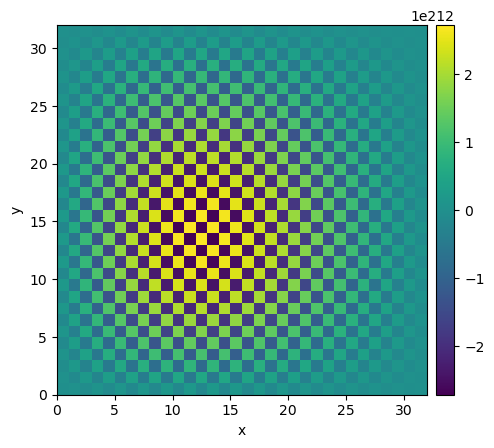

In [43]:
# test

from pde import VectorField, ScalarField, UnitGrid
import random

random.seed(42)

grid = UnitGrid([32, 32])  # generate grid
state = ScalarField.random_uniform(grid)  # generate initial condition
motion = VectorField.random_uniform(grid)

eq = affectionDiffusionPDE(motion=motion)  # define the pde
result = eq.solve(state, t_range=10, dt=0.01)
result.plot()

https://py-pde.readthedocs.io/en/latest/manual/advanced_usage.html#custom-pde-classes

# Simulate Data Using PDE Solver

For this step, we use the PDE solver `py-pde` and the instructions from [here](https://pypi.org/project/py-pde/).

In [ ]:
grid = pde.UnitGrid(64, 64)                 # generate a grid
init = pde.ScalarField.random_uniform(grid) # generate initial conditions on the grid

